In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
#Set data order
data_order = 8

In [3]:
# wandb.init(project="ads1_prj_VGG19n")


In [4]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [5]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder()
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [8]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # Dữ liệu label đã được mã hóa
# def oneHot(arr):
#     labels = np.array(arr)
#     # Khởi tạo một trình chuyển đổi OneHotEncoder
#     encoder = OneHotEncoder(sparse=False)
    
#     # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
#     labels_reshaped = labels.reshape(-1, 1)
    
#     # Fit trình chuyển đổi vào dữ liệu
#     encoder.fit(labels_reshaped)
    
#     # Chuyển đổi labels sang dạng one-hot encoding
#     onehot_labels = encoder.transform(labels_reshaped)
#     return onehot_labels

# y_train=oneHot(y_train)
# y_test=oneHot(y_test)

In [9]:
x_test.shape

(330, 42)

In [10]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [11]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [12]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [13]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [14]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    # Convert predictions to binary (0 or 1)
    y_pred = K.round(y_pred)
    
    # Calculate True Positives, False Positives and False Negatives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    
    # Calculate precision and recall for each class
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    
    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [17]:
def multi_loss(y_true, y_pred):
    # # Tính toán các loss function riêng lẻ
    focal__loss = focal_loss(y_true,y_pred)
    f1__loss = f1_loss(y_true,y_pred)
    dice__loss = dice_coef_loss(y_true,y_pred)

    # Đặt trọng số cho từng loss function (nếu cần)
    focal_weight = 0.3
    f1_weight = 0.5
    dice_weight = 0.2

    # Tổng hợp các loss function
    total_loss = (focal_weight * focal__loss) + (f1_weight * f1__loss) + (dice_weight * dice__loss)

    return total_loss

In [18]:
# -*- coding: utf-8 -*-
"""Inception-ResNet V2 model for Keras.

Model naming and structure follows TF-slim implementation (which has some additional
layers and different number of filters from the original arXiv paper):
https://github.com/tensorflow/models/blob/master/slim/nets/inception_resnet_v2.py

Pre-trained ImageNet weights are also converted from TF-slim, which can be found in:
https://github.com/tensorflow/models/tree/master/slim#pre-trained-models

# Reference
- [Inception-v4, Inception-ResNet and the Impact of
   Residual Connections on Learning](https://arxiv.org/abs/1602.07261)

"""
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np
from keras.layers import Input, Conv1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D,AveragePooling1D,Concatenate, Dense
from keras.models import Model
import keras.backend as K




def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.

    This function applies the "Inception" preprocessing which converts
    the RGB values from [0, 255] to [-1, 1]. Note that this preprocessing
    function is different from `imagenet_utils.preprocess_input()`.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def conv1d_bn(x,
              filters,
              kernel_size,
              strides=1,
              padding='same',
              activation='relu',
              name=None):
    bn_axis=1
    x = Conv1D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               name=name)(x)
    bn_name = None if name is None else name + '_bn'
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = Activation(activation, name=ac_name)(x)
    return x

from keras.layers import Lambda, ZeroPadding1D

def adjust_padding(branches):
    max_length = max(K.int_shape(branch)[1] for branch in branches)
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[1]
        if branch_length < max_length:
            padding = max_length - branch_length
            branch = ZeroPadding1D(padding=(0, padding))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def check_and_adjust_branches(branches, channel_axis):
    max_length = max([K.int_shape(branch)[channel_axis] for branch in branches])
    adjusted_branches = []
    for branch in branches:
        branch_length = K.int_shape(branch)[channel_axis]
        if branch_length != max_length:
            # Adjust the size of the branch
            # This can be done using ZeroPadding1D, Cropping1D, or other methods
            # For example, using ZeroPadding1D:
            padding_size = (max_length - branch_length)
            padding = (padding_size // 2, padding_size - padding_size // 2)
            branch = ZeroPadding1D(padding=padding)(branch)
        adjusted_branches.append(branch)
    return adjusted_branches

def adjust_branches_for_concat(branches):
    adjusted_branches = []
    for branch in branches:
        if K.int_shape(branch)[2] != 96:
            # Thêm đệm để kích thước chiều kênh tăng lên 96
            padding_size = 96 - K.int_shape(branch)[2]
            left_pad = padding_size // 2
            right_pad = padding_size - left_pad
            branch = ZeroPadding1D(padding=(left_pad, right_pad))(branch)
        adjusted_branches.append(branch)
    return adjusted_branches


def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
 
    if block_type == 'block35':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(x, 32, 1)
        branch_1 = conv1d_bn(branch_1, 32, 3)
        branch_2 = conv1d_bn(x, 32, 1)
        branch_2 = conv1d_bn(branch_2, 48, 3)
        branch_2 = conv1d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 128, 1)
        branch_1 = conv1d_bn(branch_1, 160, 1)
        branch_1 = conv1d_bn(branch_1, 192, 7)
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        target_length = K.int_shape(x)[1]
        branch_0 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(x, 192, 1)
        branch_1 = conv1d_bn(branch_1, 224, 1)
        branch_1 = conv1d_bn(branch_1, 256, 3)
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    channel_axis = -1
    branches = check_and_adjust_branches(branches, channel_axis=1)
    mixed = Concatenate(axis=channel_axis, name=block_name + '_mixed')(branches)
    up = conv1d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   name=block_name + '_conv')

    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
    return x





In [19]:
def InceptionResNetV2():

    # Determine proper input shape
    input_shape =(42,1)
    x_input = Input(shape=input_shape)

    # Stem block: 35 x 35 x 192
    x = conv1d_bn(x_input, 16, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 16, 3, padding='valid')
    x = conv1d_bn(x, 32, 3)
    x = MaxPooling1D(3, strides=2)(x)
    x = conv1d_bn(x, 80, 1, padding='valid')
    x = conv1d_bn(x, 192, 3, padding='valid')
    x = MaxPooling1D(3, strides=2)(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 160
    branch_0 = conv1d_bn(x, 64, 1)
    branch_1 = conv1d_bn(x, 48, 1)
    branch_1 = conv1d_bn(branch_1, 32, 5)
    branch_2 = conv1d_bn(x, 32, 1)
    branch_2 = conv1d_bn(branch_2, 64, 3)
    branch_2 = conv1d_bn(branch_2, 64, 3)
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 32, 1)
    target_shape = (None, 2, 64)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = -1
    #branches = adjust_branches_for_concat(branches)
    x = Concatenate(axis=-1, name='mixed_5b')(branches)

    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 160
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv1d_bn(x, 128, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 96, 1)
    branch_1 = conv1d_bn(branch_1, 96, 3)
    branch_1 = conv1d_bn(branch_1, 128, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)

    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv1d_bn(x, 96, 1)
    branch_0 = conv1d_bn(branch_0, 128, 3, strides=2, padding='same')
    branch_1 = conv1d_bn(x, 96, 1)
    branch_1 = conv1d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv1d_bn(x, 96, 1)
    branch_2 = conv1d_bn(branch_2, 288, 3)
    branch_2 = conv1d_bn(branch_2, 128, 3, strides=2, padding='same')
    branch_pool = MaxPooling1D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)

    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv1d_bn(x, 1536, 1, name='conv_7b')
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)

 

    # Create model
    model = Model(x_input, x, name='inception_resnet_v2')

    

    return model


model = InceptionResNetV2()
lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=lr), loss=multi_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)


model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 42, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 20, 16)               64        ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 20, 16)               60        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 20, 16)               0         ['batch_norm

In [20]:
model.fit(dict_data[data_order][0],dict_data[data_order][1].toarray(),
          validation_data=(dict_data[data_order][2],dict_data[data_order][3].toarray()),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback],class_weight={0: 0.654690618762475, 1: 2.1161290322580646})

Epoch 1/10000


16/16 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5629 - f1_score: 0.4850
Epoch 1: val_f1_score improved from -inf to 0.43643, saving model to best_model.h5
16/16 [==============================] - 469s 3s/step - loss: 0.6997 - accuracy: 0.5629 - f1_score: 0.4850 - val_loss: 0.6320 - val_accuracy: 0.7407 - val_f1_score: 0.4364 - lr: 0.0010
Epoch 2/10000
16/16 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.6796 - f1_score: 0.6714
Epoch 2: val_f1_score improved from 0.43643 to 0.53175, saving model to best_model.h5
16/16 [==============================] - 20s 1s/step - loss: 0.3923 - accuracy: 0.6796 - f1_score: 0.6714 - val_loss: 0.3568 - val_accuracy: 0.6914 - val_f1_score: 0.5318 - lr: 0.0010
Epoch 3/10000
16/16 [==============================] - ETA: 0s - loss: 0.3258 - accuracy: 0.7425 - f1_score: 0.7355
Epoch 3: val_f1_score did not improve from 0.53175
16/16 [==============================] - 14s 855ms/step - loss: 0.3258 - accu

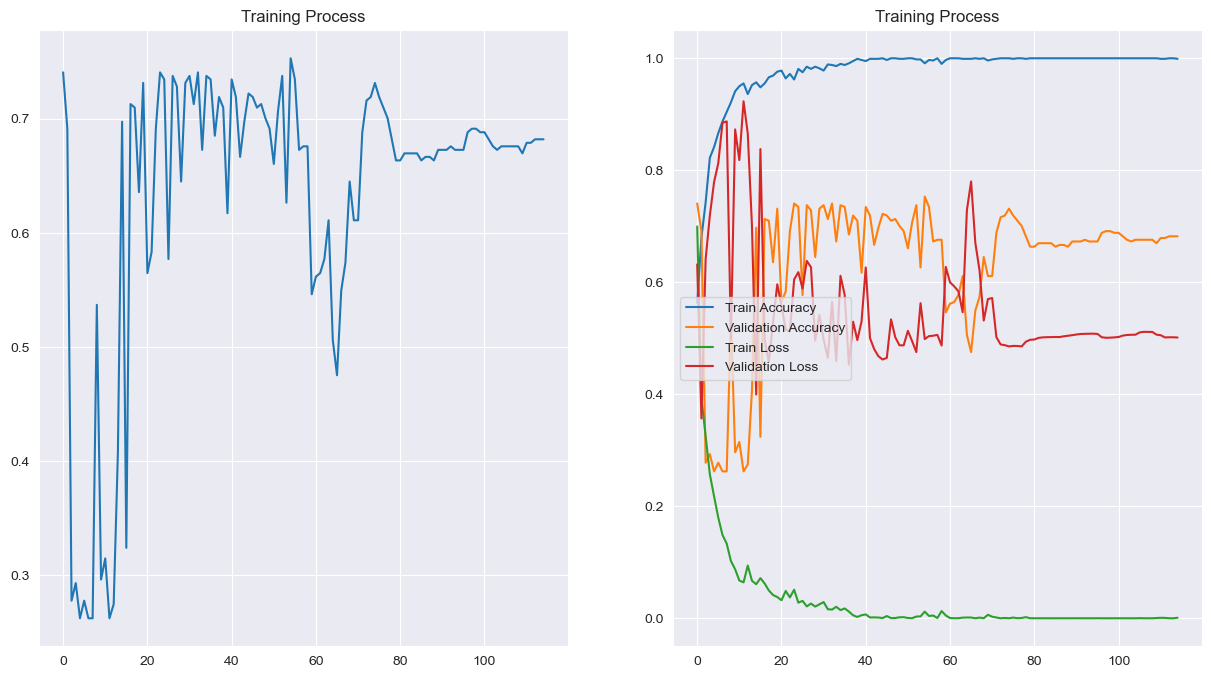

<Figure size 640x480 with 0 Axes>

In [21]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

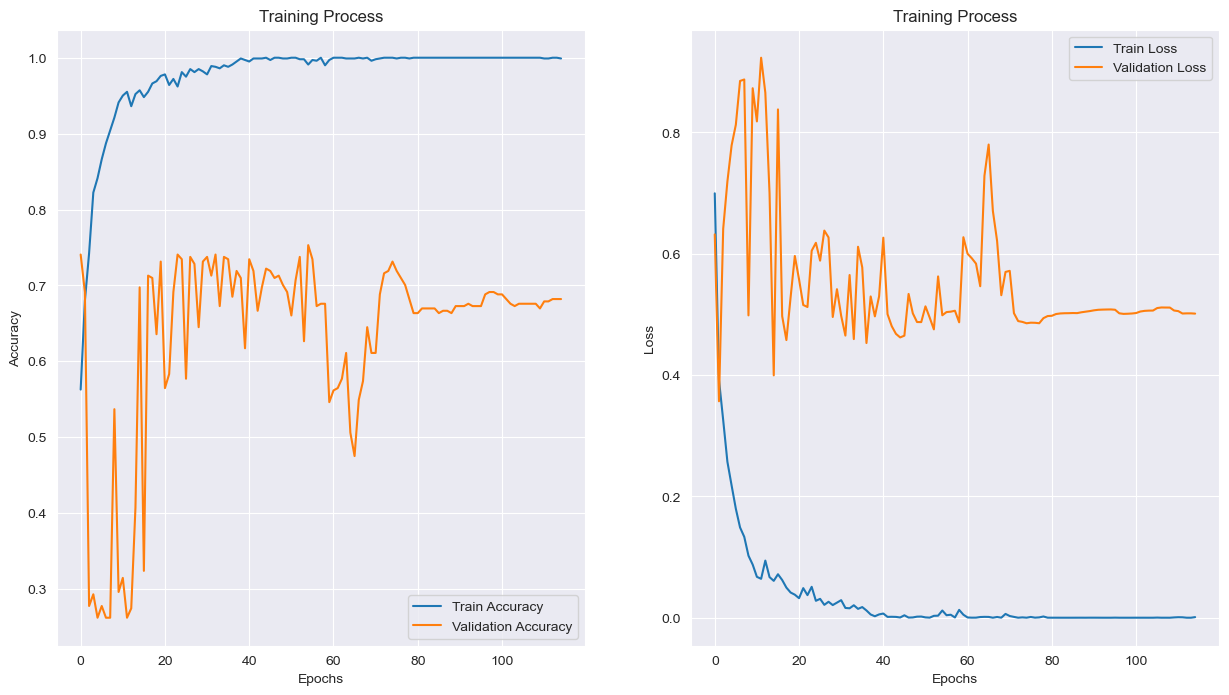

<Figure size 640x480 with 0 Axes>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [23]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 11s 63ms/step


0.6975308641975309

In [24]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy:

 0.6975308641975309
Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.46      0.44        85
           0       0.80      0.78      0.79       239

    accuracy                           0.70       324
   macro avg       0.62      0.62      0.62       324
weighted avg       0.70      0.70      0.70       324



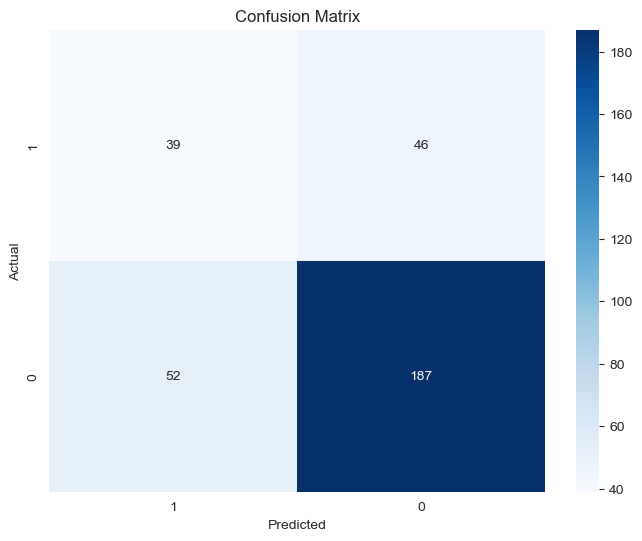

In [26]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

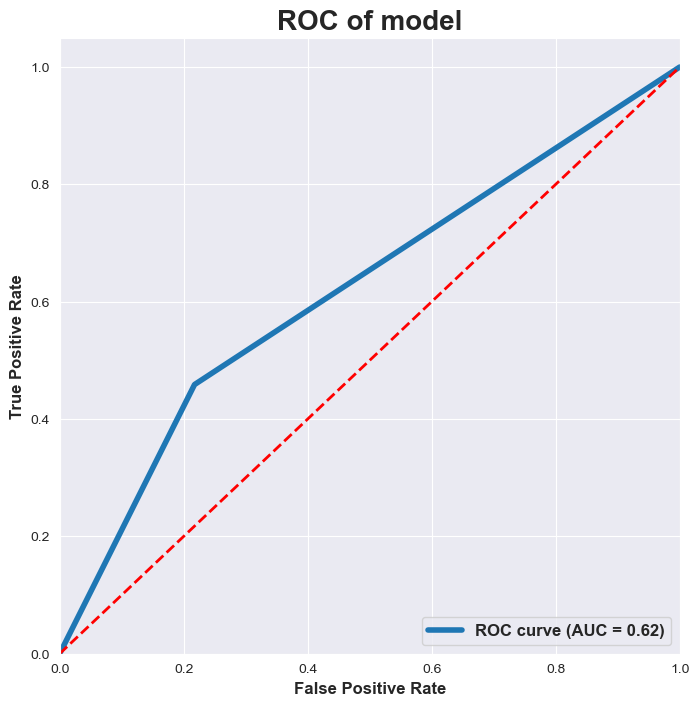

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [28]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [29]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [30]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 226 chiếm khoảng 69.75308641975309% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 39 chiếm khoảng 45.88235294117647% so với thực tế
